In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
from scipy import signal
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import ttest_ind

In [ ]:
# To ignore any warning
import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Mount the drive (if not already mounted)
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Only taking participant with accuracy more than 70%, not others. These names were already told to have 70% or more accuracy.
participants=['SUT','SUB','SOS','SLS','SHV','SAK','RUC','RAV','RAU','PRK','PAH','PAA','NIS','MOS','MAV','MAO','LAK','KRH','KAC','JAY','JAI','JAH','JAA','HIM','HAP','AYP','ASJ','ARS','AKU']

In [ ]:
# Printing the total number of participants
print("Total Number of Participants:",len(participants))

Total Number of Participants: 29


In [ ]:
# This are the parameters for Pre processing, that is used in the Old Preprocessing Pipeline.

# fs = 125  # Assuming a sampling frequency of 125 Hz
# lowcut = 0.01  # Lower cutoff frequency (in Hz)
# highcut = 1.0  # Upper cutoff frequency (in Hz)
# order = 4  # Filter order

In [ ]:
# This are the parameters for Pre processing, that is used in the Old Preprocessing Pipeline.

# def butter_bandpass_filter(data, lowcut, highcut, fs, order):
#     nyquist = 0.5 * fs
#     low = lowcut / nyquist
#     high = highcut / nyquist
#     b, a = signal.butter(order, [low, high], btype='band')
#     y = signal.lfilter(b, a, data)
#     return y

In [ ]:
# Old Preprocessing Pipeline. The new Pipeline is given later.

# def Preprocessing(df):
#   baseline_data = df.iloc[:, 3:-1]  # Select the columns for the baseline correction
#   baseline_mean = baseline_data.mean(axis=1)  # Calculate the mean across the baseline columns
#   df_corrected = df.copy()  # Create a copy of the original DataFrame
#   df_corrected.iloc[:, 3:-1] -= baseline_mean[:, np.newaxis]  # Subtract the mean from each column

#   scaler = MinMaxScaler(feature_range=(0, 1))  # Create a MinMaxScaler object
#   df_normalized = pd.DataFrame(scaler.fit_transform(df_corrected.iloc[:, 3:-1]), columns=df_corrected.columns[3:-1])

#   df_filtered = df_normalized.copy()  # Create a copy of the normalized DataFrame
#   df_filtered.iloc[:, 3:-1] = butter_bandpass_filter(df_normalized.iloc[:, 3:-1].values, lowcut, highcut, fs, order)

#   # return df_filtered
#   return pd.concat([df.iloc[:, :3], df_filtered], axis=1)

#   # baseline_data = df.loc[:, 't1':'t88']  # Select the columns for the baseline correction
#   # baseline_mean = baseline_data.mean(axis=1)  # Calculate the mean across the baseline columns
#   # df_corrected = df.copy()  # Create a copy of the original DataFrame
#   # df_corrected.loc[:, 't1':] -= baseline_mean[:, np.newaxis]  # Subtract the mean from each column

#   # scaler = MinMaxScaler(feature_range=(0, 1))  # Create a MinMaxScaler object
#   # df_normalized = pd.DataFrame(scaler.fit_transform(df_corrected.loc[:, 't1':]), columns=df_corrected.columns[3:])

#   # df_filtered = df_normalized.copy()  # Create a copy of the normalized DataFrame
#   # df_filtered.loc[:, 't1':] = butter_bandpass_filter(df_normalized.loc[:, 't1':].values, lowcut, highcut, fs, order)

#   # # return df_filtered
#   # return pd.concat([df.iloc[:, :3], df_filtered], axis=1)

In [ ]:
#New Pipleine, that is used to do Pre processing
def Preprocessing(df):
  # Drop the last column
  data = df.iloc[:, :-1]

  # Exclude images with response times outside the range of 0.200 to 0.900
  valid_images = data[(data.iloc[:, 2] >= 0.200) & (data.iloc[:, 2] <= 0.900)]

  # Ignore the first 13 pupil data
  ignored_columns = valid_images.columns[3:16]

  # Take the next 25 pupil data and calculate the mean, excluding non-numeric columns
  baseline_data = valid_images.iloc[:, 15:40].apply(
      lambda row: pd.to_numeric(row, errors='coerce').mean(), axis=1)

  # Subtract the mean from all the pupil values in each row, excluding non-numeric columns
  baseline_corrected_data = valid_images.iloc[:, 3:].apply(
      lambda row: pd.to_numeric(row, errors='coerce') - baseline_data, axis=0)

  # Calculate Z-score normalization for each image row-wise, excluding non-numeric columns
  zscore_normalized_data = baseline_corrected_data.apply(
      lambda row: (row - row.mean()) / row.std(), axis=1)

  return pd.concat([df.iloc[:, :3], zscore_normalized_data], axis=1)

In [ ]:
#As getting wrong Latency values in our code, impelemented this code provided to us.

from scipy import stats
import os
import pandas as pd
import numpy as np

# Define the path to the main directory
directory_path = '/content/gdrive/MyDrive/70ms_WithMask_BlackBG'

# Define a function to process pupil data and find the first significant value
def process_pupil_data(pupil_data):
    window_size = 5
    for i in range(len(pupil_data) - window_size):
        window1 = pupil_data[i:i+window_size]
        window2 = pupil_data[i+1:i+window_size+1]
        _, p_value = stats.ttest_rel(window1, window2)
        if p_value <= 0.05:
            time_stamp = i * 8  # Multiply by 8 to get the time stamp
            return time_stamp
    return None  # No significant value found

# Define arrays to store time stamps for each condition and participant
time_stamps = {'E1': {}, 'E2': {}, 'E3': {}}

# List of folders to ignore
ignore_folders = ['JAA', 'KRH', 'MAO', 'RAU', 'JAH', 'NIS', 'ADA', 'AMA', 'SUP', 'SYA', 'ANC', 'HRK', 'ASW', 'HIE', 'SAI', 'ASJ']

# Iterate over each participant's folder
for participant_folder in os.listdir(directory_path):
    # Skip ignored folders
    if participant_folder in ignore_folders:
        continue

    participant_path = os.path.join(directory_path, participant_folder)
    if os.path.isdir(participant_path):
        # Analyze each subfolder (E1, E2, E3) for the participant
        for subfolder_name in ['E1', 'E2', 'E3']:
            subfolder_path = os.path.join(participant_path, subfolder_name)
            file_path = os.path.join(subfolder_path, 'target.csv')

            # Load the CSV file into a dataframe
            df = pd.read_csv(file_path)

            # Take the first 163 pupil values for each image
            pupil_columns = df.columns[3:230]  # Columns containing the first 163 pupil values
            df_trimmed = df[['image_name', 'response_time'] + list(pupil_columns)].copy()

            # Apply baseline correction
            baseline_mean = df_trimmed[pupil_columns].iloc[:, 12:37].mean(axis=1)
            df_trimmed[pupil_columns] = df_trimmed[pupil_columns].sub(baseline_mean, axis=0)

            # Z-score normalization
            df_trimmed[pupil_columns] = df_trimmed[pupil_columns].apply(stats.zscore)

            # Process each image's pupil data and find the first significant value
            participant_time_stamps = []
            for _, row in df_trimmed.iterrows():
                pupil_data = row[pupil_columns].values
                time_stamp = process_pupil_data(pupil_data)
                if time_stamp is not None:
                    participant_time_stamps.append(time_stamp)

            # Store the time stamps for the participant and condition
            time_stamps[subfolder_name][participant_folder] = participant_time_stamps

#Printing all the Latency values for each Particiapnt and for each emotion (E1, E2 and E3).
for condition, condition_time_stamps in time_stamps.items():
    print(condition + ":")
    for participant, participant_time_stamps in condition_time_stamps.items():
        print("Participant", participant)
        print(participant_time_stamps)
    print()

E1:
Participant HAP
[1136, 1272, 1272, 1608, 1064, 1176, 1376, 648, 1312, 664, 960, 1176, 256, 1256, 1448, 1216]
Participant HIM
[920, 744, 1696, 1288, 248, 1088, 560, 144, 144, 232, 1664, 1600]
Participant SHV
[1344, 392, 240, 1520, 192, 120, 1240, 832, 1128, 1152, 408, 664, 1160, 1408, 224, 792, 280, 184, 560]
Participant JAI
[288, 1376, 1040, 608, 1080, 840, 1016, 1120, 1648, 1160, 1576, 752, 32, 1056, 8, 104, 752, 1072, 160, 1144, 1328, 200, 1256]
Participant ARS
[768, 1640, 448, 664, 192, 1064, 504, 1720, 648, 600, 1600, 144]
Participant LAK
[992, 136, 840, 1136, 1736, 984, 904, 512, 1232, 208, 888, 728, 1208, 392, 1176, 1136, 1272, 144, 1216]
Participant JAY
[592, 936, 1336, 1704, 1112, 688, 520, 1688, 1432, 1328]
Participant MOS
[848, 896, 8, 208, 600, 232, 752, 1416, 312, 1120, 632, 176, 904, 136]
Participant PRK
[464, 1376, 368, 80, 384, 1376, 688, 1080, 144, 1160, 864, 128, 1008, 56, 72, 312, 8, 392, 592, 1696, 1240, 512, 1200, 1176, 56]
Participant RUC
[1528, 1192, 456, 1288

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# Old way to calculate Latency value, using sliding window. Got no values as latency, beacuse as got not 5 consecutive values below 0.05 nowhere.
# def findLatency(df):

#   window_size = 5
#   selected_values = 0

#   df=np.reshape(df, (1, -1))

#   columns = [f't{i+1}' for i in range(df.shape[1])]
#   df = pd.DataFrame(df, columns=columns)

#   # print(df)

#     # Iterate over the rows
#   for _, row in df.iterrows():
#       # Get the column names starting from t1 up to where the data is present
#       columns = [col for col in row.index if col.startswith('t')]
#       print(columns)

#       # Iterate over the columns
#       for i in range(len(columns) - window_size + 1):
#           # Get the window of data
#           window_data = row[columns[i:i+window_size]]

#           # Convert window data to numeric format
#           window_data = pd.to_numeric(window_data, errors='coerce')

#           # Remove NaN values from the window data
#           window_data = window_data.dropna()

#           # Check if there are enough non-NaN values for the t-test
#           if len(window_data) >= 2:
#               # Check if all values in the window are the same
#               if window_data.nunique() != 1:
#                   # Calculate the mean
#                   window_mean = window_data.mean()

#                   # Perform the t-test between the two consecutive windows
#                   t_statistic, p_value = ttest_ind(window_data[:-1], window_data[1:])

#                   # Check if the p-value is less than the significance level (e.g., 0.05)
#                   if p_value < 0.5:
#                       # If the condition is met, take the first value of the first window
#                       selected_value = window_data.iloc[0]
#                       break

#       # If no window satisfies the condition, the selected value remains 0

#   return selected_value


#   print(selected_values)
#   df['Latency'] = selected_values

#   #Move column to 4th position
#   columns = df.columns.tolist()
#   columns.remove('Latency')

#   # Insert the column at the desired position (4th position in this case)
#   columns.insert(3, 'Latency')

#   # Reorder the columns in the DataFrame
#   df = df[columns]

#   return df
# # # Print the selected values
# # print(selected_values)


# def findLatency(participant_data):
#     window_size = 5
#     selected_values = {}

#     for participant, df in participant_data.items():

#         df = pd.DataFrame(df).transpose()
#         print(df)

#         selected_values[participant] = []

#         df = df.transpose()
#         df.columns = [f't{i+1}' for i in range(df.shape[1])]



#         for _, row in df.iterrows():
#             columns = [f't{i+1}' for i in range(df.shape[1])]

#             for i in range(len(columns) - window_size + 1):
#                 window_data = row[columns[i:i+window_size]]
#                 window_data = pd.to_numeric(window_data, errors='coerce')
#                 window_data = window_data.dropna()

#                 if len(window_data) >= 2 and window_data.nunique() != 1:
#                     window_mean = window_data.mean()
#                     t_statistic, p_value = ttest_ind(window_data[:-1], window_data[1:])
#                     print(p_value)
#                     if p_value < 0.5:
#                         selected_values[participant].append(window_data.iloc[0])
#                         break

#             else:
#                 selected_values[participant].append(0)

#     return selected_values

# t=findLatency(happy_means)
# print(t)

In [ ]:
import numpy as np
from scipy.stats import ttest_ind

# New way to calculate Latency, by doing column wise T-Test. But this method was wrong as well, becuse no 5 consecutive values were less than 0.05 here as well.
def findLatency(df):

    window_size = 5
    selected_values = []

    # Iterate over the columns
    for col in df.columns:
        # Get the column values
        column_values = df[col]

        # Iterate over the values in the column
        for i in range(len(column_values) - window_size + 1):
            # Get the window of data
            window_data = column_values[i:i+window_size]

            # Convert window data to numeric format
            window_data = pd.to_numeric(window_data, errors='coerce')

            # Remove NaN values from the window data
            window_data = window_data.dropna()

            # Check if there are enough non-NaN values for the t-test
            if len(window_data) >= 2:
                # Check if all values in the window are the same
                if window_data.nunique() != 1:
                    # Calculate the mean
                    window_mean = window_data.mean()

                    # Perform the t-test between the two consecutive windows
                    t_statistic, p_value = ttest_ind(window_data[:-1], window_data[1:])
                    # print(p_value)
                    # Check if the p-value is less than the significance level (e.g., 0.05)
                    if p_value < 0.5:
                        # If the condition is met, take the first value of the first window
                        selected_values.append(window_data.iloc[0])
                        break

        # If no window satisfies the condition, append 0
        else:
            selected_values.append(0)

    return selected_values

In [ ]:
# import numpy as np
# from scipy.stats import ttest_ind

# Old way to calculate latency. Not used here as df format was changed.
# def findLatency(df):
#     window_size = 5
#     selected_values = []
#     amplitude_values = []

#     # Iterate over the columns
#     for col in df.columns:
#         # Get the column values
#         column_values = df[col]

#         # Iterate over the values in the column
#         for i in range(len(column_values) - window_size + 1):
#             # Get the window of data
#             window_data = column_values[i:i+window_size]

#             # Convert window data to numeric format
#             window_data = pd.to_numeric(window_data, errors='coerce')

#             # Remove NaN values from the window data
#             window_data = window_data.dropna()

#             # Check if there are enough non-NaN values for the t-test
#             if len(window_data) >= 2:
#                 # Check if all values in the window are the same
#                 if window_data.nunique() != 1:
#                     # Calculate the mean
#                     window_mean = window_data.mean()

#                     # Perform the t-test between the two consecutive windows
#                     t_statistic, p_value = ttest_ind(window_data[:-1], window_data[1:])

#                     # Check if the p-value is less than the significance level (e.g., 0.05)
#                     if p_value < 0.5:
#                         # If the condition is met, take the first value of the first window
#                         selected_values.append(window_data.iloc[0])
#                         # Calculate the amplitude (minimum and maximum values) for the window
#                         amplitude_values.append([window_data.min(), window_data.max()])
#                         break

#         # If no window satisfies the condition, append 0 for both selected value and amplitude
#         else:
#             selected_values.append(0)
#             amplitude_values.append([0, 0])

#     return selected_values, amplitude_values

# latency_values, amplitude_values = findLatency(happy_mean_df)

# # Create a new DataFrame with the latency, amplitude1, and amplitude2 values
# result_df = pd.DataFrame({
#     'Participant': happy_mean_df.columns,
#     'Latency': latency_values,
#     'Amplitude1': [amp[0] for amp in amplitude_values],
#     'Amplitude2': [amp[1] for amp in amplitude_values]
# })

# # Print the resulting DataFrame
# print(result_df)


In [ ]:
#Old way to calculate amplitude from dataframe. Not used here as df format was changed.
# def calculate_amplitude(df):
#     # Initialize empty dictionaries to store amplitudes for each type of face
#     happy_amplitudes = {}
#     angry_amplitudes = {}
#     neutral_amplitudes = {}

#     # Iterate over the rows
#     for idx, row in df.iterrows():
#         image_name = row["image_name"]

#         # Check the type of face based on the image name
#         if image_name.endswith("1.png"):
#             amplitudes = happy_amplitudes
#         elif image_name.endswith("2.png"):
#             amplitudes = angry_amplitudes
#         elif image_name.endswith("0.png"):
#             amplitudes = neutral_amplitudes
#         else:
#             continue

#         # Calculate the column-wise mean for columns 4 to 162
#         column_means = row.iloc[4:163].mean(axis=0)

#         # Convert column_means to a Series
#         column_means = pd.Series(column_means)

#         # Update the amplitudes dictionary with the minimum values
#         if "Amplitude" not in amplitudes or column_means.min() < amplitudes.get("Amplitude", np.inf):
#             amplitudes["Amplitude"] = column_means.min()

#     # Add the "Amplitude" column to the original DataFrame
#     df["Amplitude"] = np.nan

#     # Update the "Amplitude" column values based on the dictionaries
#     for idx, row in df.iterrows():
#         image_name = row["image_name"]

#         if image_name.endswith("1.png"):
#             amplitude = happy_amplitudes.get("Amplitude", 0)
#         elif image_name.endswith("2.png"):
#             amplitude = angry_amplitudes.get("Amplitude", 0)
#         elif image_name.endswith("0.png"):
#             amplitude = neutral_amplitudes.get("Amplitude", 0)
#         else:
#             continue

#         df.at[idx, "Amplitude"] = amplitude

#     # Move column to 5th position
#     columns = df.columns.tolist()
#     columns.remove("Amplitude")

#     # Insert the column at the desired position (5th position in this case)
#     columns.insert(4, "Amplitude")

#     # Reorder the columns in the DataFrame
#     df = df[columns]
#     return df


In [ ]:
import numpy as np
import pandas as pd
from scipy.signal import argrelextrema

#New way to calculate amplitude from dictionary of mean values
def calculate_amplitude(df):
  # Initialize empty dictionaries to store results for each participant
    amplitudes = {}
    gradients = {}

    # Iterate over the columns of the DataFrame
    for column in df.columns:
        # Skip the non-participant columns
        if column in ['Time', 'Amplitude', 'MinGradient', 'MaxGradient']:
            continue

        # Get the values for the current participant
        participant_values = df[column].values

        # Find the indices of the valid values (non-NaN)
        valid_indices = np.where(~np.isnan(participant_values))[0]

        # Skip the column if all values are NaN
        if len(valid_indices) == 0:
            continue


        # Find the indices of the minimum and maximum values among the valid values
        min_index = valid_indices[np.argmin(participant_values[valid_indices])]
        max_index = valid_indices[np.argmax(participant_values[valid_indices])]

        # Get the minimum and maximum values
        min_amplitude = participant_values[min_index]
        max_amplitude = participant_values[max_index]

        # Calculate the gradient at the minimum and maximum points
        min_gradient = np.gradient(participant_values)[min_index]
        max_gradient = np.gradient(participant_values)[max_index]

        # Update the dictionaries with the results
        amplitudes[column] = (min_amplitude, max_amplitude)
        gradients[column] = (min_gradient, max_gradient)

    # Create DataFrames to store the results
    amplitude_df = pd.DataFrame.from_dict(amplitudes, orient='index', columns=['MinAmplitude', 'MaxAmplitude'])
    gradient_df = pd.DataFrame.from_dict(gradients, orient='index', columns=['MinGradient', 'MaxGradient'])
    results_df = pd.concat([amplitude_df, gradient_df], axis=1)
    results_df.index.name = 'Participant'

    return results_df

In [ ]:
#To plot the graph

# Initialize empty dictionaries to store mean DataFrames for each type
happy_means = {}
angry_means = {}
neutral_means = {}

for p in participants:
  # Specify the path to the Excel file
  fp1='/content/gdrive/MyDrive/70ms_WithMask_BlackBG/'+p+'/E1/target.csv'
  fp2='/content/gdrive/MyDrive/70ms_WithMask_BlackBG/'+p+'/E2/target.csv'
  fp3='/content/gdrive/MyDrive/70ms_WithMask_BlackBG/'+p+'/E3/target.csv'

  # Read the CSV file into a DataFrame
  df1 = pd.read_csv(fp1)
  df2 = pd.read_csv(fp2)
  df3 = pd.read_csv(fp3)

  #Applying the Preprocessing Pipeline
  df1_preprocessed=Preprocessing(df1)
  df2_preprocessed=Preprocessing(df2)
  df3_preprocessed=Preprocessing(df3)

  # Filter DataFrame for happy participants
  happy_df = df1_preprocessed

  # Filter DataFrame for angry participants
  angry_df = df2_preprocessed

  # Filter DataFrame for neutral participants
  neutral_df = df3_preprocessed

  # Not replaced NaN values with 0, as don't want to take them while calculating mean. So easier for us to ignore.
  # happy_df=happy_df.fillna(0)
  # angry_df=angry_df.fillna(0)
  # neutral_df=neutral_df.fillna(0)

  # Calculate mean for each type and store in respective dictionaries
  happy_row_df = happy_df.iloc[:, 3:].mean(skipna=True)
  angry_row_df = angry_df.iloc[:, 3:].mean(skipna=True)
  neutral_row_df = neutral_df.iloc[:, 3:].mean(skipna=True)

  # Not replaced NaN values with 0, as don't want to take them while calculating mean. So easier for us to ignore.
  # happy_row_df=happy_row_df.fillna(0)
  # angry_row_df=angry_row_df.fillna(0)
  # neutral_row_df=neutral_row_df.fillna(0)

  # Store the row DataFrames in the respective dictionaries
  happy_means[p] = happy_row_df
  angry_means[p] = angry_row_df
  neutral_means[p] = neutral_row_df

In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_ind
from scipy.stats import ttest_rel

#Wrong way to calculate latency from dataframe, where taking all values less than 0.05, but should have taken only the first value.
def find_latency(df):
    window_size = 6
    selected_values = []

    # Iterate over the columns
    for i in range(len(df.columns) - window_size + 1):
        # Get the column names for the window
        window_cols = df.columns[i : i + window_size]

        # Perform the t-test between consecutive columns in the window
        p_values = [ttest_ind(df[window_cols[j]], df[window_cols[j + 1]],equal_var=False)[1] for j in range(window_size - 1)]
        print(p_values)
        print("\n")

        # Check if all p-values in the window are less than 0.05
        if all(p < 0.05 for p in p_values):
            # Take the first column name as the latency value
            latency_col = window_cols[0]
            selected_values.append(int(latency_col[1:]) * 8)  # Convert column name to latency value in ms
            lat=int(latency_col[1:]) * 8
            return
        else:
            selected_values.append(np.nan)
            lat=0
            return
    # print(latency_col[1:])

    return pd.DataFrame({'Latency': selected_values})

# Apply find_latency function to the given DataFrame
latency_df = find_latency(happy_df.iloc[:, 3:])

print(latency_df)

[0.7857642288466461, 0.9375926736839483, 0.9965532234177058, 0.9544912354685569, 0.9016413325228134]


None


In [ ]:
# Append zeros to arrays with shorter lengths to make all uniform length
max_length = max(len(arr) for arr in happy_means.values())
for key in happy_means.keys():
    arr = happy_means[key]
    if len(arr) < max_length:
        happy_means[key] = np.concatenate((arr, np.full(max_length - len(arr), np.nan)))

max_length = max(len(arr) for arr in angry_means.values())
for key in angry_means.keys():
    arr = angry_means[key]
    if len(arr) < max_length:
        angry_means[key] = np.concatenate((arr, np.full(max_length - len(arr), np.nan)))

max_length = max(len(arr) for arr in neutral_means.values())
for key in neutral_means.keys():
    arr = neutral_means[key]
    if len(arr) < max_length:
        neutral_means[key] = np.concatenate((arr, np.full(max_length - len(arr), np.nan)))

# Create DataFrames from the dictionaries
happy_mean_df = pd.DataFrame(happy_means)
angry_mean_df = pd.DataFrame(angry_means)
neutral_mean_df = pd.DataFrame(neutral_means)

# Concatenate mean DataFrames for each type into a single DataFrame
happy_mean_df = pd.concat([happy_mean_df], axis=1)
angry_mean_df = pd.concat([angry_mean_df], axis=1)
neutral_mean_df = pd.concat([neutral_mean_df], axis=1)

In [ ]:
# Calculate column-wise mean across all participants for each type
happy_column_mean = happy_mean_df.mean(skipna=True,axis=1)
angry_column_mean = angry_mean_df.mean(skipna=True,axis=1)
neutral_column_mean = neutral_mean_df.mean(skipna=True,axis=1)

# Print the resulting mean DataFrames and column-wise mean for each type
print("Happy Mean DataFrame:")
print(happy_mean_df)
print("\nAngry Mean DataFrame:")
print(angry_mean_df)
print("\nNeutral Mean DataFrame:")
print(neutral_mean_df)
print("\nHappy Column-wise Mean:")
print(happy_column_mean)
print("\nAngry Column-wise Mean:")
print(angry_column_mean)
print("\nNeutral Column-wise Mean:")
print(neutral_column_mean)

Happy Mean DataFrame:
            SUT       SUB       SOS       SLS       SHV       SAK       RUC  \
t1     0.021960  0.253250  0.888494  0.227068  1.081947  0.934094  0.183597   
t2     0.005960  0.254177  0.922419  0.263996  1.086814  0.936543  0.183405   
t3     0.027975  0.306819  0.951184  0.316655  1.132964  0.929726  0.253359   
t4     0.025605  0.286401  0.962648  0.294132  1.114301  0.945585  0.295517   
t5     0.041489  0.273481  0.939016  0.329409  1.151676  0.964167  0.239179   
...         ...       ...       ...       ...       ...       ...       ...   
t1394       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
t1395       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
t1396       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
t1397       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
t1398       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

            RAV       RAU    

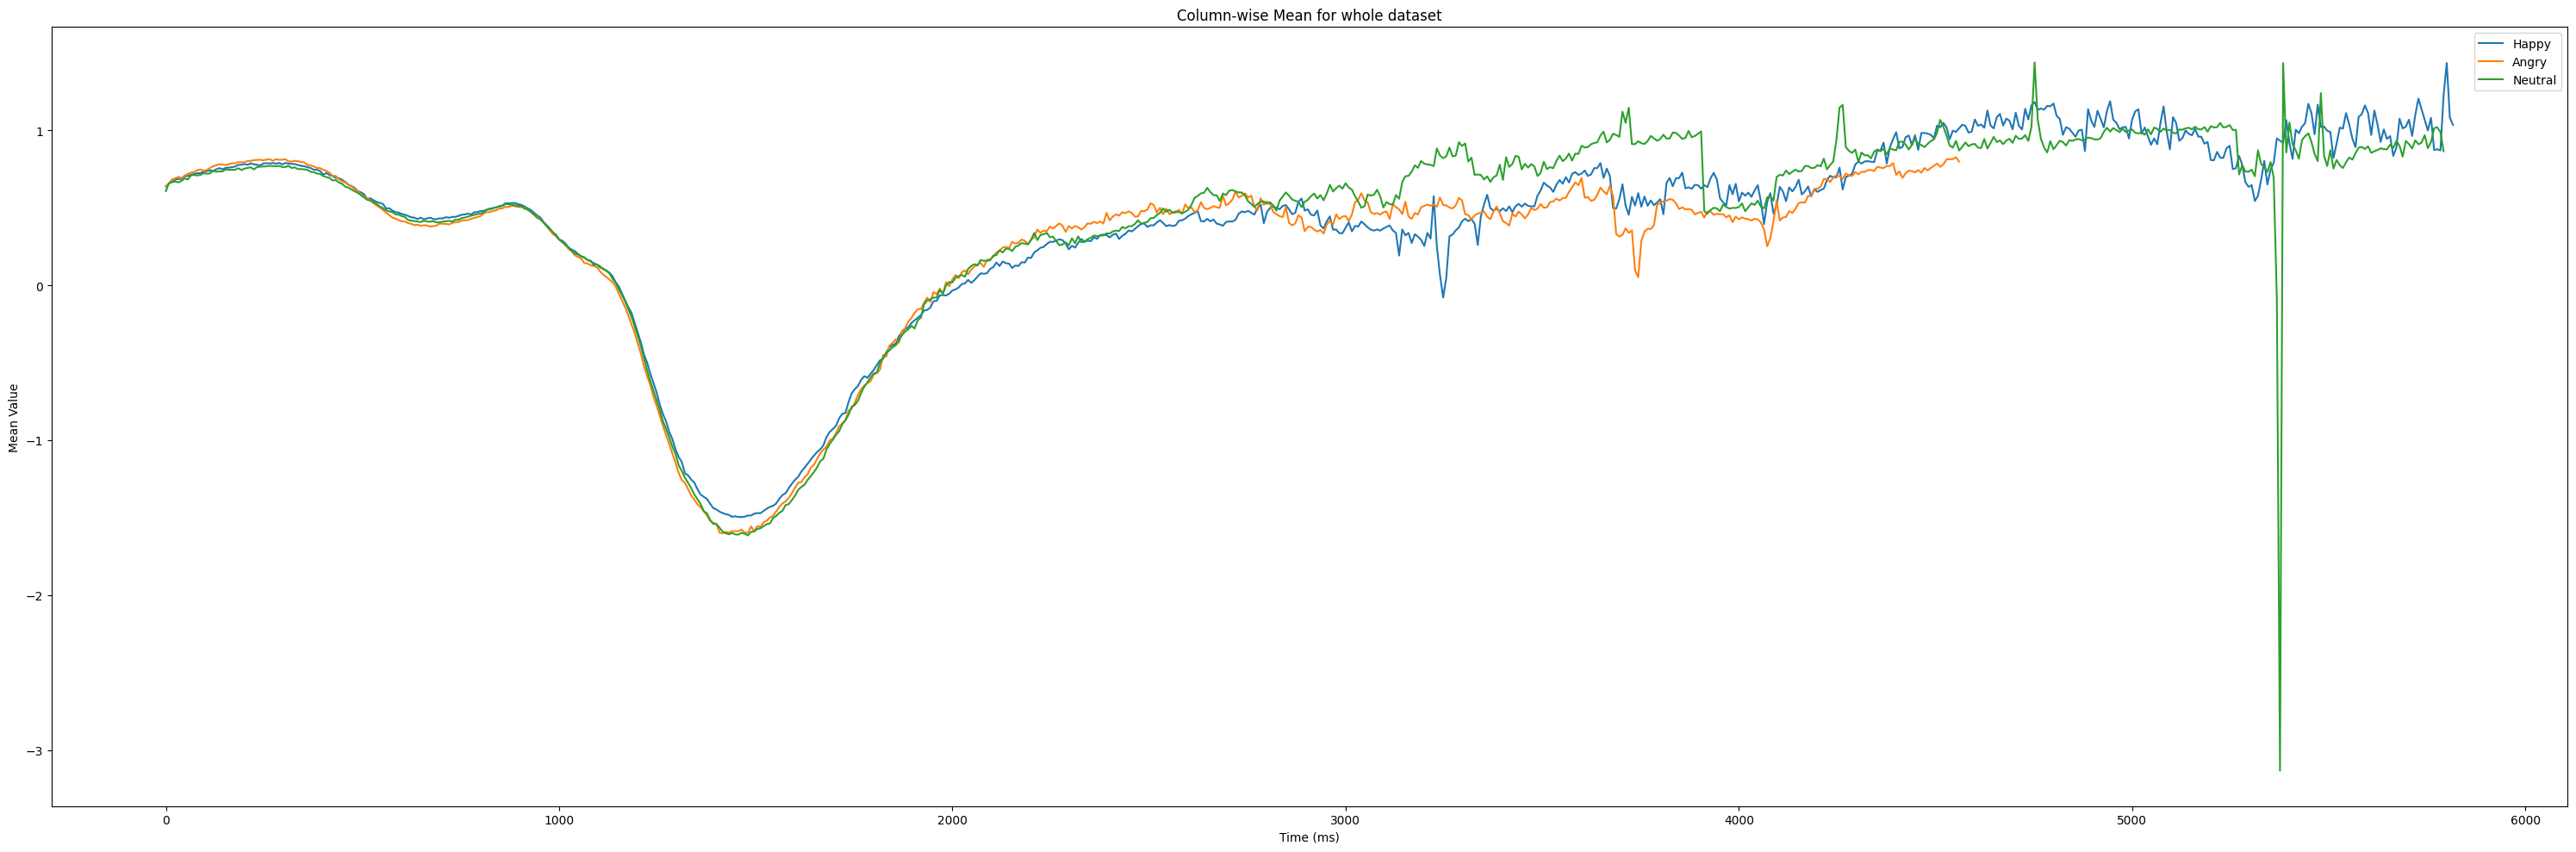

In [ ]:
import matplotlib.pyplot as plt

# Plot the column-wise mean for whole dataset
# plt.subplot(2, 2, 4)
plt.figure(figsize=(30, 10))

# Calculate the x-axis values based on the desired interval
x_happy_values = [i * 8 for i in range (len(happy_column_mean))]
x_angry_values = [i * 8 for i in range (len(angry_column_mean))]
x_neutral_values = [i * 8 for i in range (len(neutral_column_mean))]

plt.title("Column-wise Mean for whole dataset")
plt.plot(x_happy_values,happy_column_mean, label="Happy")
plt.plot(x_angry_values,angry_column_mean, label="Angry")
plt.plot(x_neutral_values,neutral_column_mean, label="Neutral")

plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Mean Value")

plt.tight_layout()
plt.show()

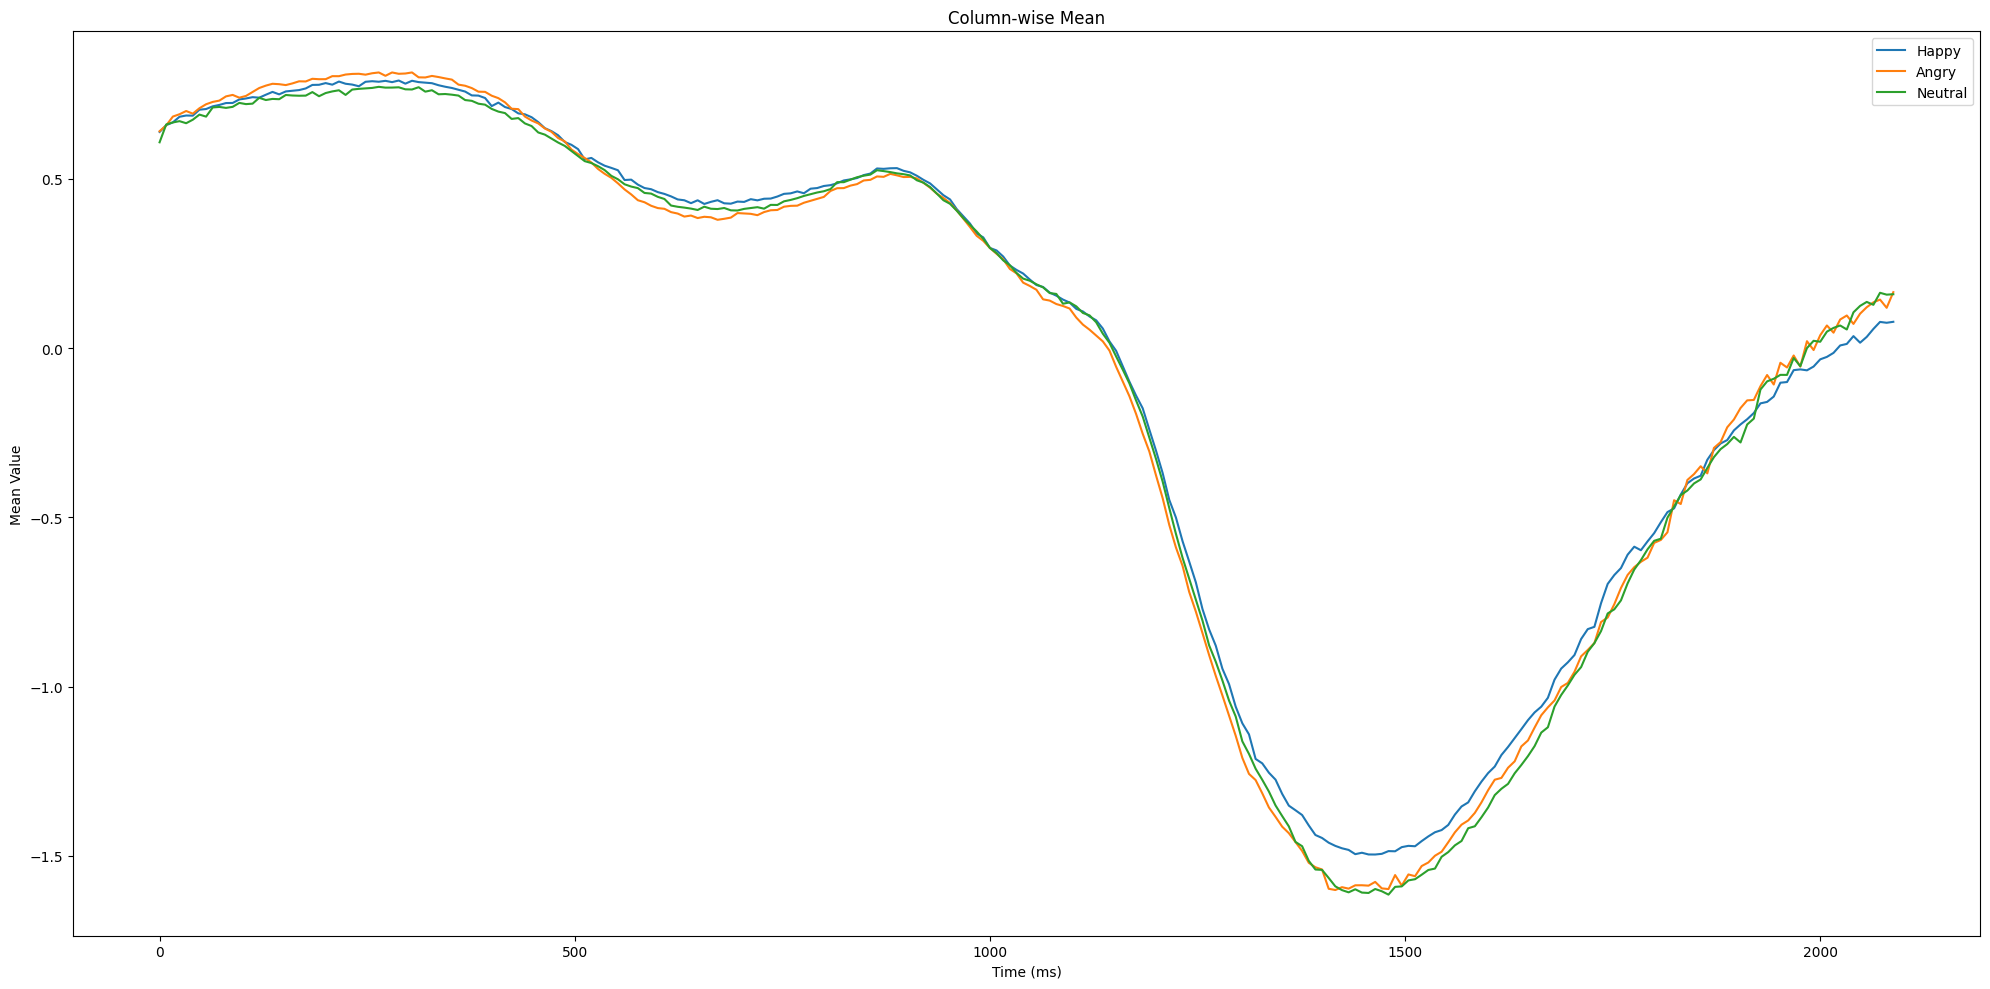

In [ ]:
import matplotlib.pyplot as plt

# Plot the column-wise mean till around 2000 ms
# plt.subplot(2, 2, 4)
plt.figure(figsize=(20, 10))

# Calculate the x-axis values based on the desired interval
x_happy_values = [i * 8 for i in range (len(happy_column_mean[:262]))]
x_angry_values = [i * 8 for i in range (len(angry_column_mean[:262]))]
x_neutral_values = [i * 8 for i in range (len(neutral_column_mean[:262]))]

plt.title("Column-wise Mean")
plt.plot(x_happy_values,happy_column_mean[:262], label="Happy")
plt.plot(x_angry_values,angry_column_mean[:262], label="Angry")
plt.plot(x_neutral_values,neutral_column_mean[:262], label="Neutral")

plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Mean Value")

plt.tight_layout()
plt.show()

In [ ]:
#Wrongly calculated latency values, as did column wise T-Test, which was wrong approach.

latency_values_happy = findLatency(happy_mean_df)
# Create a new DataFrame with the latency values
print('Latency for Happy DataFrame')
latency_df_happy = pd.DataFrame({'Participant': happy_mean_df.columns, 'Latency': latency_values_happy})

# Print the resulting latency DataFrame
print(latency_df_happy)


latency_values_angry = findLatency(angry_mean_df)
# Create a new DataFrame with the latency values
print('\n\nLatency for Angry DataFrame')
latency_df_angry = pd.DataFrame({'Participant': angry_mean_df.columns, 'Latency': latency_values_angry})

# Print the resulting latency DataFrame
print(latency_df_angry)


latency_values_neutral = findLatency(neutral_mean_df)
# Create a new DataFrame with the latency values
print('\n\nLatency for Neutral DataFrame')
latency_df_neutral = pd.DataFrame({'Participant': neutral_mean_df.columns, 'Latency': latency_values_neutral})

# Print the resulting latency DataFrame
print(latency_df_neutral)

Latency for Happy DataFrame
   Participant   Latency
0          SUT  0.005960
1          SUB  0.254177
2          SOS  0.967245
3          SLS  0.227068
4          SHV  1.081947
5          SAK  0.934094
6          RUC  0.253359
7          RAV  0.366878
8          RAU  0.760201
9          PRK  0.598609
10         PAH  0.330237
11         PAA  0.777051
12         NIS  0.788352
13         MOS  0.609353
14         MAV  0.598194
15         MAO  0.812438
16         LAK  0.986131
17         KRH  0.711057
18         KAC  0.851222
19         JAY  0.588321
20         JAI  0.676559
21         JAH  0.890828
22         JAA  0.582029
23         HIM  0.580828
24         HAP  0.907544
25         AYP  0.455641
26         ASJ  0.518375
27         ARS  0.799460
28         AKU  0.865772


Latency for Angry DataFrame
   Participant   Latency
0          SUT -0.107313
1          SUB  0.711042
2          SOS  0.791166
3          SLS  0.389832
4          SHV  0.789530
5          SAK  0.927898
6          RUC  0

In [ ]:
# Calculating the amplitudes and gradients, both min and max.
happy_add_ampli = calculate_amplitude(happy_mean_df)
print('Happy Amplitude and Gradient')
print(happy_add_ampli)

angry_add_ampli = calculate_amplitude(angry_mean_df)
print('\n\nAngry Amplitude and Gradient')
print(angry_add_ampli)

neutral_add_ampli = calculate_amplitude(neutral_mean_df)
print('\n\nNeutral Amplitude and Gradient')
print(neutral_add_ampli)

Happy Amplitude and Gradient
             MinAmplitude  MaxAmplitude  MinGradient  MaxGradient
Participant                                                      
SUT             -1.451481      0.653187    -0.012273    -0.343906
SUB             -3.332026      3.180693     0.029407    -0.228063
SOS             -1.897176      1.048832    -0.011737    -0.021163
SLS             -1.878738      0.950930     0.023371     0.006721
SHV             -2.019322      1.294543    -0.029594     0.076605
SAK             -2.042946      1.125123    -0.006889     0.023566
RUC             -1.413875      1.391230     0.000749    -0.025465
RAV             -1.954797      0.817886     0.010848          NaN
RAU             -1.863663      2.186605    -0.008365          NaN
PRK             -1.692882      0.853736     0.000863     0.012805
PAH             -1.990368      1.207643    -0.008750          NaN
PAA             -1.925349      1.124395    -0.007016    -0.009180
NIS             -2.175967      1.204980     0.0

In [ ]:
#Printing the wrongly calculated latency, amplitudes and gradients.

final_happy=pd.concat([latency_df_happy.set_index('Participant'), happy_add_ampli], axis=1)
print('Final parameters of Happy Dataframe')
print(final_happy)

final_angry=pd.concat([latency_df_angry.set_index('Participant'), angry_add_ampli], axis=1)
print('\n\nFinal parameters of Angry Dataframe')
print(final_angry)

final_neutral=pd.concat([latency_df_neutral.set_index('Participant'), neutral_add_ampli], axis=1)
print('\n\nFinal parameters of Neutral Dataframe')
print(final_neutral)

Final parameters of Happy Dataframe
              Latency  MinAmplitude  MaxAmplitude  MinGradient  MaxGradient
Participant                                                                
SUT          0.005960     -1.451481      0.653187    -0.012273    -0.343906
SUB          0.254177     -3.332026      3.180693     0.029407    -0.228063
SOS          0.967245     -1.897176      1.048832    -0.011737    -0.021163
SLS          0.227068     -1.878738      0.950930     0.023371     0.006721
SHV          1.081947     -2.019322      1.294543    -0.029594     0.076605
SAK          0.934094     -2.042946      1.125123    -0.006889     0.023566
RUC          0.253359     -1.413875      1.391230     0.000749    -0.025465
RAV          0.366878     -1.954797      0.817886     0.010848          NaN
RAU          0.760201     -1.863663      2.186605    -0.008365          NaN
PRK          0.598609     -1.692882      0.853736     0.000863     0.012805
PAH          0.330237     -1.990368      1.207643   

In [ ]:
# Wrongly calculated latency values (Did Column wise T Test) upto 162, not whole dataset.

latency_values_happy_1 = findLatency(happy_mean_df.loc['t1':'t162'])
# Create a new DataFrame with the latency values
print('Latency for Happy DataFrame')
latency_df_happy_1 = pd.DataFrame({'Participant': happy_mean_df.loc['t1':'t162'].columns, 'Latency': latency_values_happy_1})

# Print the resulting latency DataFrame
print(latency_df_happy_1)

happy_add_ampli_1 = calculate_amplitude(happy_mean_df.loc['t1':'t162'])
print('Happy Amplitude and Gradient')
print(happy_add_ampli_1)

final_happy_1=pd.concat([latency_df_happy_1.set_index('Participant'), happy_add_ampli_1], axis=1)
print('Final parameters of Happy Dataframe')
print(final_happy_1)

Latency for Happy DataFrame
   Participant   Latency
0          SUT  0.005960
1          SUB  0.254177
2          SOS  0.967245
3          SLS  0.227068
4          SHV  1.081947
5          SAK  0.934094
6          RUC  0.253359
7          RAV  0.366878
8          RAU  0.760201
9          PRK  0.598609
10         PAH  0.330237
11         PAA  0.777051
12         NIS  0.788352
13         MOS  0.609353
14         MAV  0.598194
15         MAO  0.812438
16         LAK  0.986131
17         KRH  0.711057
18         KAC  0.851222
19         JAY  0.588321
20         JAI  0.676559
21         JAH  0.890828
22         JAA  0.582029
23         HIM  0.580828
24         HAP  0.907544
25         AYP  0.455641
26         ASJ  0.518375
27         ARS  0.799460
28         AKU  0.865772
Happy Amplitude and Gradient
             MinAmplitude  MaxAmplitude  MinGradient  MaxGradient
Participant                                                      
SUT             -0.061571      0.477382    -0.060733    -0.00

Below codes gave wrong graphs, which led to discovery of the Bug: Should have taken all the entries, not slice of dataset, and had to correct the Preprocessing Pipeline.

In [ ]:
# def calculate_gradient(df):
#     # Calculate the gradient at the point of Latency for each row
#     df["Gradient"] = np.gradient(df["Latency"])

#     # Move the "Gradient" column to the desired position (6th position in this case)
#     columns = df.columns.tolist()
#     columns.remove("Gradient")
#     columns.insert(5, "Gradient")
#     df = df[columns]

#     return df

In [ ]:
# # t=calculate_gradient(df1_add_ampli)
# df1_add_latency=findLatency(df1_preprocessed)
# # df1_add_latency=findLatency(df1)
# df1_add_ampli=calculate_amplitude(df1_add_latency)
# t=calculate_gradient(df1_add_ampli)
# t

In [ ]:
# def calculate_gradient(df):
#     # Create an empty list to store the gradient values
#     gradients = []

#     # Iterate over the rows
#     for _, row in df.iterrows():
#         # Get the value in the "Latency" column
#         latency = row["Latency"]

#         # Find the column index corresponding to the "Latency" value
#         latency_column_idx = row.index.get_loc("Latency")

#         # Convert the row data to a numeric array
#         row_data = pd.to_numeric(row[latency_column_idx:], errors="coerce").values

#         # Calculate the gradient at the "Latency" value
#         gradient = np.gradient(row_data)[0]

#         # Append the gradient value to the list
#         gradients.append(gradient)

#     # Add the "Gradient" column to the DataFrame
#     df["Gradient"] = gradients

#     # Move the "Gradient" column to the desired position (6th position in this case)
#     columns = df.columns.tolist()
#     columns.remove("Gradient")
#     columns.insert(5, "Gradient")

#     # Reorder the columns in the DataFrame
#     df = df[columns]
#     return df

In [ ]:
# import matplotlib.pyplot as plt

# # t=calculate_gradient(df1_add_ampli)
# df1_add_latency=findLatency(df1_preprocessed)
# # df1_add_latency=findLatency(df1)
# df1_add_ampli=calculate_amplitude(df1_add_latency)
# t=calculate_gradient(df1_add_ampli)

# # Select the rows to plot
# rows_to_plot = t.iloc[[0, 1, 2]]

# # Extract the time values from columns t1 to t162
# time_values = range(8, 1297, 8)

# # plt.figure(figsize=(30, 20))

# # Plot the data for each row
# for _, row in rows_to_plot.iterrows():
#     plt.plot(time_values, row["t1":"t162"], label=row["image_name"])

#     # Get the values for Latency, Gradient, and Amplitude
#     latency = row["Latency"]
#     gradient = row["Gradient"]
#     amplitude = row["Amplitude"]

#     # Plot Latency as a vertical straight line
#     plt.plot([time_values[int(latency)*8]], [latency], 'r|', markersize=20, label="Latency")

#     # Plot Gradient as a vertical straight line
#     plt.plot([time_values[int(gradient)*8]], [gradient], 'g|', markersize=20, label="Gradient")

#     # Plot Amplitude as a vertical straight line
#     plt.plot([time_values[int(amplitude)*8]], [amplitude], 'b|', markersize=20, label="Amplitude")

# # Set the x-axis label
# plt.xlabel("Time (ms)")

# # Set the y-axis label
# plt.ylabel("Value")

# # Set the title
# plt.title("Plot of first 3 Rows")

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# # t=calculate_gradient(df1_add_ampli)
# # df1_add_latency=findLatency(df1_preprocessed)
# df1_add_latency=findLatency(df1)
# df1_add_ampli=calculate_amplitude(df1_add_latency)
# t=calculate_gradient(df1_add_ampli)


# import matplotlib.pyplot as plt

# # Select the rows to plot
# rows_to_plot = t.iloc[[0, 1, 2]]

# # Extract the time values from columns t1 to t162
# time_values = range(8, 1297, 8)

# # plt.figure(figsize=(30, 20))

# # Plot the data for each row
# for _, row in rows_to_plot.iterrows():
#     plt.plot(time_values, row["t1":"t162"], label=row["image_name"])

#     # Get the values for Latency, Gradient, and Amplitude
#     latency = row["Latency"]
#     gradient = row["Gradient"]
#     amplitude = row["Amplitude"]

#     # Plot Latency as a vertical straight line
#     plt.plot([time_values[int(latency)*8]], [latency], 'r|', markersize=20, label="Latency")

#     # Plot Gradient as a vertical straight line
#     plt.plot([time_values[int(gradient)*8]], [gradient], 'g|', markersize=20, label="Gradient")

#     # Plot Amplitude as a vertical straight line
#     plt.plot([time_values[int(amplitude)*8]], [amplitude], 'b|', markersize=20, label="Amplitude")

# # Set the x-axis label
# plt.xlabel("Time (ms)")

# # Set the y-axis label
# plt.ylabel("Value")

# # Set the title
# plt.title("Plot of first 3 Rows")

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()


In [ ]:
# # t=calculate_gradient(df1_add_ampli)
# # df1_add_latency=findLatency(df1_preprocessed)
# df1_add_latency=findLatency(df1)
# df1_add_ampli=calculate_amplitude(df1_add_latency)
# t=calculate_gradient(df1_add_ampli)


# import matplotlib.pyplot as plt

# # Select the rows to plot
# rows_to_plot = t.iloc[[0, 1, 2]]

# # Extract the time values from columns t1 to t162
# time_values = range(8, 1297, 8)

# # plt.figure(figsize=(30, 20))

# # Plot the data for each row
# for _, row in rows_to_plot.iterrows():
#     plt.plot(time_values, row["t1":"t162"], label=row["image_name"])


# # Set the x-axis label
# plt.xlabel("Time (ms)")

# # Set the y-axis label
# plt.ylabel("Value")

# # Set the title
# plt.title("Plot of first 3 Rows")

# # Add a legend
# plt.legend()

# # Show the plot
# plt.show()
